In [ ]:
!apt-get install tesseract-ocr
!sudo apt install tesseract-ocr-deu
!pip install pytesseract
!pip install pdf2image
!apt-get install poppler-utils
!pip install opencv-python
!pip install albumentations==0.4.6
!pip install fasttext==0.9.2


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,838 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
import torch  # Import PyTorch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for preprocessing.")
else:
    device = torch.device('cpu')
    print("GPU not available, using CPU.")

Using GPU for preprocessing.


In [ ]:
import os

pdf_folder = "/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2"
pdf_files = [f for f in os.listdir(pdf_folder) if f.lower().endswith('.pdf')]

print(f"Found {len(pdf_files)} PDF files.")


Found 8 PDF files.


**Convert PDFs to Images:**

In [ ]:
from pdf2image import convert_from_path
import tqdm
"""
def convert_pdf_to_images(pdf_path, output_folder, dpi=300):

    # Convert PDF to images
    pages = convert_from_path(pdf_path, dpi=dpi)

    image_paths = []
    for page_number, page in enumerate(pages, start=1):
        image_filename = f"{os.path.splitext(os.path.basename(pdf_path))[0]}_page_{page_number}.png"
        image_path = os.path.join(output_folder, image_filename)
        page.save(image_path, 'PNG')
        image_paths.append(image_path)
    return image_paths

# Create an output directory for images
output_image_folder = os.path.join(pdf_folder, "images")
os.makedirs(output_image_folder, exist_ok=True)

# Convert all PDFs to images
for pdf_file in tqdm.tqdm(pdf_files, desc="Converting PDFs to images"):
    pdf_path = os.path.join(pdf_folder, pdf_file)
    convert_pdf_to_images(pdf_path, output_image_folder)
"""

'\ndef convert_pdf_to_images(pdf_path, output_folder, dpi=300):\n\n    # Convert PDF to images\n    pages = convert_from_path(pdf_path, dpi=dpi)\n\n    image_paths = []\n    for page_number, page in enumerate(pages, start=1):\n        image_filename = f"{os.path.splitext(os.path.basename(pdf_path))[0]}_page_{page_number}.png"\n        image_path = os.path.join(output_folder, image_filename)\n        page.save(image_path, \'PNG\')\n        image_paths.append(image_path)\n    return image_paths\n\n# Create an output directory for images\noutput_image_folder = os.path.join(pdf_folder, "images")\nos.makedirs(output_image_folder, exist_ok=True)\n\n# Convert all PDFs to images\nfor pdf_file in tqdm.tqdm(pdf_files, desc="Converting PDFs to images"):\n    pdf_path = os.path.join(pdf_folder, pdf_file)\n    convert_pdf_to_images(pdf_path, output_image_folder)\n'

**Preprocessing Function:**

In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path, output_path):
    """Preprocesses the image using GPU if available."""
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Move image to GPU
    gray_tensor = torch.tensor(gray, device=device, dtype=torch.uint8).unsqueeze(0) # Add batch dimension
                                                                              # and move to GPU


    # GPU-accelerated CLAHE is not directly available in OpenCV/PyTorch
    # So, we perform CLAHE on the CPU and then move the result back to the tensor
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_cpu = clahe.apply(gray)
    enhanced = torch.tensor(enhanced_cpu, device=device, dtype=torch.uint8).unsqueeze(0)


    # Perform Otsu's on CPU (Otsu's on GPU can be tricky)
    _, binary_cpu = cv2.threshold(enhanced_cpu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Move back to CPU to save
    cv2.imwrite(output_path, binary_cpu)


**Process All Images:**

In [ ]:
"""preprocessed_folder = os.path.join(pdf_folder, "preprocessed_images")
os.makedirs(preprocessed_folder, exist_ok=True)

image_files = [f for f in os.listdir(output_image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))] # More image extensions


for image_file in tqdm.tqdm(image_files, desc="Preprocessing images"):
    image_path = os.path.join(output_image_folder, image_file)
    output_path = os.path.join(preprocessed_folder, image_file)
    preprocess_image(image_path, output_path)"""

'preprocessed_folder = os.path.join(pdf_folder, "preprocessed_images")\nos.makedirs(preprocessed_folder, exist_ok=True)\n\nimage_files = [f for f in os.listdir(output_image_folder) if f.lower().endswith((\'.png\', \'.jpg\', \'.jpeg\'))] # More image extensions\n\n\nfor image_file in tqdm.tqdm(image_files, desc="Preprocessing images"):\n    image_path = os.path.join(output_image_folder, image_file)\n    output_path = os.path.join(preprocessed_folder, image_file)\n    preprocess_image(image_path, output_path)'

**Extract Text and Layout Information:**

In [ ]:
import pytesseract
from pytesseract import Output

def extract_layout(image_path):
    """Extracts text and layout information."""
    image = cv2.imread(image_path)
    custom_config = r'--oem 3 --psm 6'  # Adjust PSM if needed (e.g., 1 for single-column)
    ocr_data = pytesseract.image_to_data(image, output_type=Output.DATAFRAME, config=custom_config)
    return ocr_data

In [ ]:
import pytesseract
from pytesseract import Output

# Setting the path to the tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


def extract_layout(image_path):
    """
    Extracts text and layout information, trying different PSM values.
    """

    image = cv2.imread(image_path)
    best_psm = 6
    best_ocr_data = None
    highest_mean_conf = 0

    for psm in [1, 3, 6]:
        try:
            custom_config = f'--oem 3 --psm {psm} -l deu'
            ocr_data = pytesseract.image_to_data(image, output_type=Output.DATAFRAME, config=custom_config)

            # Filter out non-textual data and calculate mean confidence
            text_conf = ocr_data[ocr_data['text'].notna()]['conf'].mean()
            if text_conf > highest_mean_conf:
                highest_mean_conf = text_conf
                best_psm = psm
                best_ocr_data = ocr_data


        except Exception as e:
            print(f"Error with PSM {psm}: {e}")


    if best_ocr_data is None:  # If all PSMs fail, return empty DataFrame
        print("All PSM values failed for this image")
        return pd.DataFrame()



    # if mean confident is low then try to sharp the image
    if highest_mean_conf < 70:  # Threshold to trigger sharpening
        print("Trying sharpening....")
        kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharpened = cv2.filter2D(image, -1, kernel)

        try:
            custom_config = f'--oem 3 --psm {best_psm}'
            sharpened_ocr_data = pytesseract.image_to_data(sharpened, output_type=Output.DATAFRAME, config=custom_config)
            sharpen_conf = sharpened_ocr_data[sharpened_ocr_data['text'].notna()]['conf'].mean()
            if sharpen_conf > highest_mean_conf:
                print("Sharpening improved results.")
                return sharpened_ocr_data
            else:
                return best_ocr_data
        except:
            print("Sharpening did not help; using original.")
            return best_ocr_data

    return best_ocr_data

**Process Preprocessed Images:**

In [ ]:
"""import pandas as pd
import os

ocr_results_folder = os.path.join(pdf_folder, "ocr_results")
os.makedirs(ocr_results_folder, exist_ok=True)

for image_file in tqdm.tqdm(image_files, desc="Extracting OCR data"):
    image_path = os.path.join(preprocessed_folder, image_file)
    ocr_data = extract_layout(image_path)
    csv_filename = os.path.splitext(image_file)[0] + '.csv'
    csv_path = os.path.join(ocr_results_folder, csv_filename)
    ocr_data.to_csv(csv_path, index=False)"""

'import pandas as pd\nimport os\n\nocr_results_folder = os.path.join(pdf_folder, "ocr_results")\nos.makedirs(ocr_results_folder, exist_ok=True)\n\nfor image_file in tqdm.tqdm(image_files, desc="Extracting OCR data"):\n    image_path = os.path.join(preprocessed_folder, image_file)\n    ocr_data = extract_layout(image_path)\n    csv_filename = os.path.splitext(image_file)[0] + \'.csv\'\n    csv_path = os.path.join(ocr_results_folder, csv_filename)\n    ocr_data.to_csv(csv_path, index=False)'

In [ ]:
!ls /usr/share/tesseract-ocr/4.00/tessdata

configs  deu.traineddata  eng.traineddata  osd.traineddata  pdf.ttf  tessconfigs


In [ ]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Using CPU")


Using GPU: Tesla T4


**Step 1: Generating Segmentation Masks**

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import os
import json
from tqdm import tqdm

def create_segmentation_masks(annotation_csv, images_folder, masks_folder, class_mapping):
    """
    Creates segmentation masks from annotations.

    Parameters:
    - annotation_csv (str): Path to the annotations CSV file.
    - images_folder (str): Path to the folder containing the images.
    - masks_folder (str): Path to the folder to save the masks.
    - class_mapping (dict): Mapping from annotation labels to class IDs.
    """
    annotations = pd.read_csv(annotation_csv)
    grouped = annotations.groupby('filename')

    for filename, group in tqdm(grouped, desc="Generating masks"):
        image_path = os.path.join(images_folder, filename)
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = Image.open(image_path)
        width, height = image.size
        mask = Image.new('L', (width, height), 0)  # 'L' mode for (8-bit pixels, black and white)

        draw = ImageDraw.Draw(mask)
        for _, row in group.iterrows():
            # Parse the JSON strings
            region_shape_attributes = json.loads(row['region_shape_attributes'])
            region_attributes = json.loads(row['region_attributes'])

            # Extract class label
            types_dict = region_attributes.get('Types', {})
            class_label = next((key for key, value in types_dict.items() if value), None)
            if class_label is None:
                continue  # Skip if no class label

            class_id = class_mapping.get(class_label)
            if class_id is None:
                print(f"Class label '{class_label}' not found in class mapping. Skipping.")
                continue  # Skip if class label is not in the mapping

            # Draw the shape on the mask
            if region_shape_attributes['name'] == 'rect':
                x = region_shape_attributes['x']
                y = region_shape_attributes['y']
                width_rect = region_shape_attributes['width']
                height_rect = region_shape_attributes['height']
                shape = [(x, y), (x + width_rect, y + height_rect)]
                draw.rectangle(shape, fill=class_id)
            elif region_shape_attributes['name'] == 'polygon':
                all_points_x = region_shape_attributes['all_points_x']
                all_points_y = region_shape_attributes['all_points_y']
                points = list(zip(all_points_x, all_points_y))
                draw.polygon(points, fill=class_id)
            # Add other shape types if needed

        # Save the mask
        mask_filename = os.path.splitext(filename)[0] + '_mask.png'
        mask_path = os.path.join(masks_folder, mask_filename)
        mask.save(mask_path, format='PNG', compress_level=0)

In [ ]:
import pandas as pd
import numpy as np

def create_text_confidence_map(ocr_csv_path, image_size):
    """
    Creates a text confidence map from OCR data.
    Parameters:
    - ocr_csv_path (str): Path to the OCR CSV file.
    - image_size (tuple): Size of the image (width, height).
    Returns:
    - confidence_map (numpy.ndarray): 2D array with confidence scores.
    """
    ocr_data = pd.read_csv(ocr_csv_path)
    confidence_map = np.zeros((image_size[1], image_size[0]), dtype=np.float32)  # (height, width)

    for _, row in ocr_data.iterrows():
        if int(row['conf']) > 0:
            x, y, w, h = int(row['left']), int(row['top']), int(row['width']), int(row['height'])
            conf = float(row['conf']) / 100.0  # Normalize confidence to [0,1]
            x_end = min(x + w, image_size[0])
            y_end = min(y + h, image_size[1])
            x_start = max(x, 0)
            y_start = max(y, 0)
            confidence_map[y_start:y_end, x_start:x_end] = conf

    return confidence_map

def create_text_mask(ocr_csv_path, image_size):
    """
    Creates a binary text mask from OCR data.
    Parameters:
    - ocr_csv_path (str): Path to the OCR CSV file.
    - image_size (tuple): Size of the image (width, height).
    Returns:
    - text_mask (numpy.ndarray): 2D binary array indicating text regions.
    """
    ocr_data = pd.read_csv(ocr_csv_path)
    text_mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)  # (height, width)

    for _, row in ocr_data.iterrows():
        if int(row['conf']) > 0:
            x, y, w, h = int(row['left']), int(row['top']), int(row['width']), int(row['height'])
            x_end = min(x + w, image_size[0])
            y_end = min(y + h, image_size[1])
            x_start = max(x, 0)
            y_start = max(y, 0)
            text_mask[y_start:y_end, x_start:x_end] = 1

    return text_mask


In [ ]:
# Define paths
annotation_csv = '/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2/Annotation/via_project_10Oct2024_20h42m_csv.csv'
images_folder = '/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2/preprocessed_images'
masks_folder = '/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2/masks'
ocr_folder = '/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2/ocr_results'

In [ ]:

# Create masks folder if it doesn't exist
os.makedirs(masks_folder, exist_ok=True)

class_mapping = {
    '0': 0,   # Background
    '1': 1,   # Main Heading
    '2': 2,   # Subheading
    '3': 3,   # Label
    '4': 4,   # Note
    '5': 5,   # Paragraphs
    '6': 6,   # List (Sections)
    '7': 7,   # Lists
    '8': 8,   # Page Number
    '9': 9,   # Footer
    '10': 10, # Author/Source
    '11': 11, # Date
    '12': 12, # Document Number
    '13': 13, # Table
    '14': 14  # Table-Columns
}

In [ ]:
# Generate masks
#create_segmentation_masks(annotation_csv, images_folder, masks_folder, class_mapping)

## Step 2: Preparing the Dataset

In [ ]:
import gzip
import fasttext
import fasttext.util
import numpy as np
from sklearn.decomposition import PCA


# path of decompressed pre-trained model
model_path = '/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2/fasttext/cc.de.300.bin'

# Load the model
try:
    ft = fasttext.load_model(model_path)
except ValueError as e:
    print(f"Error loading model: {e}")
    raise e

# Fit PCA on the embeddings
embedding_dim = 300
reduced_dim = 50
pca = PCA(n_components=reduced_dim)

# Collect all embeddings to fit PCA
all_embeddings = []
for word in ft.get_words():
    embedding = ft.get_word_vector(word)
    all_embeddings.append(embedding)
all_embeddings = np.array(all_embeddings)
pca.fit(all_embeddings)

PCA(n_components=50)

In [ ]:
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform
import numpy as np

class RGBNormalize(ImageOnlyTransform):
    def __init__(self, mean, std, always_apply=False, p=1.0):
        super(RGBNormalize, self).__init__(always_apply, p)
        self.mean = np.array(mean)
        self.std = np.array(std)

    def apply(self, img, **params):
        img = img.astype(np.float32)
        img[:, :, :3] = (img[:, :, :3] - self.mean) / self.std  # Normalize only RGB
        return img

    def get_transform_init_args_names(self):
        return ("mean", "std")


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the mean and std for RGB channels
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define additional targets for multimodal data
additional_targets = {
    'confidence_map': 'mask',
    'text_mask': 'mask',
    'mask':'mask'
}

# Create the transformation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
    A.Resize(height=512, width=512),
    RGBNormalize(mean=mean, std=std, always_apply=True, p=1.0),
    ToTensorV2(),
], additional_targets=additional_targets)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import os
import cv2
import numpy as np

class DocumentLayoutDataset(Dataset):
    def __init__(self, images_folder, masks_folder, ocr_folder, transform=None, multimodal=True, target_size=(512, 512), embedding_dim=300):
        super().__init__()
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.ocr_folder = ocr_folder
        self.transform = transform
        self.multimodal = multimodal
        self.target_size = target_size
        self.embedding_dim = embedding_dim

        self.image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
        self.image_files = [
            f for f in self.image_files
            if os.path.exists(os.path.join(masks_folder, os.path.splitext(f)[0] + '_mask.png'))
        ]

    def resize_tensor(self, tensor, target_size):
        """Resize a tensor to target size"""
        if len(tensor.shape) == 2:
            tensor = tensor.unsqueeze(0)
        return F.interpolate(tensor.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False).squeeze(0)

    def __getitem__(self, idx):
        # Load image and mask
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_folder, image_filename)
        mask_path = os.path.join(self.masks_folder, os.path.splitext(image_filename)[0] + '_mask.png')

        # Load and process image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.target_size)
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        # Load and process mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)
        mask = torch.from_numpy(mask).long()

        if self.multimodal:
            # Create dummy multimodal features for now
            # In practice, you would load these from your OCR data
            confidence_map = torch.zeros(1, *self.target_size)
            text_mask = torch.zeros(1, *self.target_size)
            text_embedding = torch.zeros(self.embedding_dim, *self.target_size)

            # Concatenate all features
            image = torch.cat([image, confidence_map, text_mask, text_embedding], dim=0)

        return image, mask

    def __len__(self):
        return len(self.image_files)

    def create_text_embedding_map(self, ocr_csv_path, target_size):
        """Creates a text embedding map from OCR data."""
        ocr_data = pd.read_csv(ocr_csv_path)
        height, width = target_size
        embedding_dim = self.ft.get_dimension()
        embedding_map = np.zeros((height, width, embedding_dim), dtype=np.float32)

        for _, row in ocr_data.iterrows():
            if isinstance(row['text'], str) and int(row['conf']) > 0:
                # Scale coordinates to target size
                x = int(row['left'] * width / row['width'])
                y = int(row['top'] * height / row['height'])
                w = int(row['width'] * width / row['width'])
                h = int(row['height'] * height / row['height'])

                word = row['text']
                embedding = self.ft.get_word_vector(word)

                x_end = min(x + w, width)
                y_end = min(y + h, height)
                x_start = max(x, 0)
                y_start = max(y, 0)

                embedding_map[y_start:y_end, x_start:x_end, :] = embedding

        return embedding_map

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class DRFN_Multimodal(nn.Module):
    def __init__(self, num_classes, embedding_dim=300):
        super(DRFN_Multimodal, self).__init__()
        # Calculate total input channels
        self.in_channels = 3 + 1 + 1 + embedding_dim  # RGB + confidence_map + text_mask + text_embedding

        # Initialize ResNet with modified first layer
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Create new first conv layer with correct number of input channels
        self.conv1 = nn.Conv2d(self.in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Initialize the first 3 channels (RGB) with pretrained weights
        with torch.no_grad():
            self.conv1.weight[:, :3, :, :] = resnet.conv1.weight
            # Initialize the remaining channels with small random values
            if self.in_channels > 3:
                nn.init.normal_(self.conv1.weight[:, 3:, :, :], mean=0, std=0.02)

        # Rest of the model remains the same
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.aux_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.Sigmoid()  # Output pixel values between 0 and 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        features = self.layer2(x)  # Capture features from an intermediate layer
        x = self.layer3(features)
        x = self.layer4(x)
        segmentation_output = self.decoder(x)
        reconstruction_output = self.aux_decoder(x)
        return segmentation_output, reconstruction_output, features


In [ ]:
class DRFN_VisualOnly(nn.Module):
    def __init__(self, num_classes):
        super(DRFN_VisualOnly, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.decoder(x)
        return x


In [ ]:
def compute_consistency_loss(features, masks):
    # features: Tensor of shape (batch_size, channels, height, width)
    # masks: Tensor of shape (batch_size, height, width)
    loss = 0.0
    batch_size = features.size(0)
    for i in range(batch_size):
        unique_labels = masks[i].unique()
        for label in unique_labels:
            if label == 0:  # Assuming 0 is background, skip if desired
                continue
            mask = (masks[i] == label).float()
            mask = mask.unsqueeze(0)  # Add channel dimension
            region_features = features[i] * mask
            region_mean = region_features.sum(dim=(1, 2)) / mask.sum()
            variance = ((region_features - region_mean.unsqueeze(1).unsqueeze(2)) ** 2 * mask).sum() / mask.sum()
            loss += variance
    return loss / batch_size


In [ ]:
def compute_class_weights(masks_folder, num_classes):
    total_pixels = 0
    class_counts = np.zeros(num_classes)
    mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.png')]
    for mask_file in mask_files:
        mask_path = os.path.join(masks_folder, mask_file)
        mask = Image.open(mask_path)
        mask_array = np.array(mask)
        unique_values = np.unique(mask_array)
        print(f"Mask {mask_file} unique values: {unique_values}")
        # Ensure mask is single-channel
        if len(mask_array.shape) == 3:
            mask_array = mask_array[:, :, 0]
        for cls in range(num_classes):
            class_counts[cls] += np.sum(mask_array == cls)
        total_pixels += mask_array.size
    # Avoid division by zero
    class_counts[class_counts == 0] = 1
    class_weights = total_pixels / (num_classes * class_counts)
    return torch.FloatTensor(class_weights)


# Compute class weights
class_weights = compute_class_weights(masks_folder, num_classes=15).to(device)

# Define the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)


print("Class Weights:", class_weights)

Mask 30s_edelmetallpruefer_1938_pruefungsanforderungen_page_1_mask.png unique values: [0 1 2 3 4 5 6 7 8]
Mask 30s_edelmetallpruefer_1938_pruefungsanforderungen_page_2_mask.png unique values: [ 0  1  2  9 10 11]
Mask brd_damenmaentelnaeherin_1954_bb_page_1_mask.png unique values: [0 1 2 3 5 6 7 9]
Mask 30s_edelmetallpruefer_1938_pruefungsanforderungen_page_3_mask.png unique values: [0 1 2 3 4 5 6 7]
Mask brd_damenschneiderin_1941_bb_page_1_mask.png unique values: [0 1 2 3 6 7 9]
Mask brd_datenverarbeitungskaufmann_1969_bb+bp+pa_page_10_mask.png unique values: [0 5 6 7 8]
Mask brd_datenverarbeitungskaufmann_1969_bb+bp+pa_page_18_mask.png unique values: [ 0  2  6  7  8 13]
Mask brd_datenverarbeitungskaufmann_1969_bb+bp+pa_page_15_mask.png unique values: [0 3 5 6 8]
Mask brd_datenverarbeitungskaufmann_1969_bb+bp+pa_page_2_mask.png unique values: [0 1 7]
Mask brd_datenverarbeitungskaufmann_1969_bb+bp+pa_page_3_mask.png unique values: [0 1 2 3 5 6 7 8]
Mask brd_datenverarbeitungskaufmann_19

#**Training Loop**

**Step 4: Training the Model with 20 Epochs**

In [ ]:
import torch
import torch.nn.functional as F
import os

def compute_consistency_loss(features, masks):
    """
    Computes the consistency loss to encourage similar feature representations within the same semantic regions.
    Parameters:
    - features: Tensor of shape (batch_size, channels, height, width)
    - masks: Tensor of shape (batch_size, height, width)
    Returns:
    - loss: Scalar tensor representing the consistency loss
    """
    loss = 0.0
    batch_size = features.size(0)
    for i in range(batch_size):
        unique_labels = masks[i].unique()
        for label in unique_labels:
            if label == 0:  # Assuming 0 is background; skip if desired
                continue
            mask = (masks[i] == label).float()
            mask = mask.unsqueeze(0)  # Add channel dimension
            region_features = features[i] * mask
            region_mean = region_features.sum(dim=(1, 2)) / (mask.sum() + 1e-8)
            variance = ((region_features - region_mean.unsqueeze(1).unsqueeze(2)) ** 2 * mask).sum() / (mask.sum() + 1e-8)
            loss += variance
    return loss / batch_size

def train_model(model, criterion_segmentation, criterion_reconstruction, optimizer, scheduler, train_loader, val_loader, num_epochs, device, lambda_recon=0.5, lambda_cons=0.1):
    """
    Trains the model with reconstruction and consistency losses.
    Parameters:
    - model: The neural network model
    - criterion_segmentation: Loss function for segmentation (e.g., CrossEntropyLoss)
    - criterion_reconstruction: Loss function for reconstruction (e.g., MSELoss)
    - optimizer: Optimizer (e.g., Adam)
    - scheduler: Learning rate scheduler
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - num_epochs: Number of epochs to train
    - device: Device to use ('cuda' or 'cpu')
    - lambda_recon: Weight for the reconstruction loss
    - lambda_cons: Weight for the consistency loss
    """
    best_loss = float('inf')
    early_stopping_patience = 5
    epochs_no_improve = 0
    save_dir = '/content/drive/MyDrive/GCOLAB Master Thesis/New final experiment/datasets_new_v2/saved_models'
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs, reconstructions, features = model(images)

            # Resize outputs if necessary
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                reconstructions = F.interpolate(reconstructions, size=images.shape[-2:], mode='bilinear', align_corners=False)
                features = F.interpolate(features, size=masks.shape[-2:], mode='bilinear', align_corners=False)

            # Compute segmentation loss
            loss_segmentation = criterion_segmentation(outputs, masks)

            # Compute reconstruction loss (use only RGB channels)
            images_rgb = images[:, :3, :, :]
            loss_reconstruction = criterion_reconstruction(reconstructions, images_rgb)

            # Compute consistency loss
            loss_consistency = compute_consistency_loss(features, masks)

            # Total loss
            total_loss = loss_segmentation + lambda_recon * loss_reconstruction + lambda_cons * loss_consistency

            # Backward and optimize
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item() * images.size(0)

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Loss: {total_loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs, reconstructions, features = model(images)

                # Resize outputs if necessary
                if outputs.shape[-2:] != masks.shape[-2:]:
                    outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                    reconstructions = F.interpolate(reconstructions, size=images.shape[-2:], mode='bilinear', align_corners=False)
                    features = F.interpolate(features, size=masks.shape[-2:], mode='bilinear', align_corners=False)

                # Compute losses
                loss_segmentation = criterion_segmentation(outputs, masks)
                images_rgb = images[:, :3, :, :]
                loss_reconstruction = criterion_reconstruction(reconstructions, images_rgb)
                loss_consistency = compute_consistency_loss(features, masks)

                total_loss = loss_segmentation + lambda_recon * loss_reconstruction + lambda_cons * loss_consistency
                val_loss += total_loss.item() * images.size(0)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        print(f'Validation Loss: {val_epoch_loss:.4f}')

        # Learning rate scheduling
        scheduler.step(val_epoch_loss)

        # Early stopping
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, os.path.join(save_dir, 'best_model.pth'))
            print('Model saved!')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping!")
                break

    print('Training complete.')


num_classes = 15
embedding_dim = 300
batch_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize dataset with multimodal=True
dataset = DocumentLayoutDataset(
    images_folder=images_folder,
    masks_folder=masks_folder,
    ocr_folder=ocr_folder,
    multimodal=True,
    embedding_dim=embedding_dim
)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to the device
model = DRFN_Multimodal(num_classes=num_classes, embedding_dim=embedding_dim).to(device)

# Define loss functions
criterion_segmentation = nn.CrossEntropyLoss(weight=class_weights).to(device)
criterion_reconstruction = nn.MSELoss().to(device)

# Define optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Number of epochs
num_epochs = 50

# Call the train_model function
train_model(
    model,
    criterion_segmentation,
    criterion_reconstruction,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    num_epochs,
    device,
    lambda_recon=0.5,
    lambda_cons=0.1
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 226MB/s]


Epoch 1, Batch 0, Loss: 6.6022
Epoch 1/50, Training Loss: 5.3051
Validation Loss: 3.7310
Model saved!
Epoch 2, Batch 0, Loss: 4.7307
Epoch 2/50, Training Loss: 4.5447
Validation Loss: 3.7330
Epoch 3, Batch 0, Loss: 4.8781
Epoch 3/50, Training Loss: 4.1057
Validation Loss: 3.6448
Model saved!
Epoch 4, Batch 0, Loss: 4.3629
Epoch 4/50, Training Loss: 3.7991
Validation Loss: 3.5520
Model saved!
Epoch 5, Batch 0, Loss: 3.5037
Epoch 5/50, Training Loss: 3.5856
Validation Loss: 3.4604
Model saved!
Epoch 6, Batch 0, Loss: 3.3118
Epoch 6/50, Training Loss: 3.3860
Validation Loss: 3.3755
Model saved!
Epoch 7, Batch 0, Loss: 3.6455
Epoch 7/50, Training Loss: 3.2677
Validation Loss: 3.2837
Model saved!
Epoch 8, Batch 0, Loss: 3.2125
Epoch 8/50, Training Loss: 3.1381
Validation Loss: 3.2044
Model saved!
Epoch 9, Batch 0, Loss: 3.0433
Epoch 9/50, Training Loss: 3.0275
Validation Loss: 3.1451
Model saved!
Epoch 10, Batch 0, Loss: 2.8582
Epoch 10/50, Training Loss: 2.9558
Validation Loss: 3.0294
Mode

In [ ]:
import cv2

for images, masks in train_loader:
    print(f"Input image shape: {images.shape}")
    print(f"Mask shape: {masks.shape}")
    break


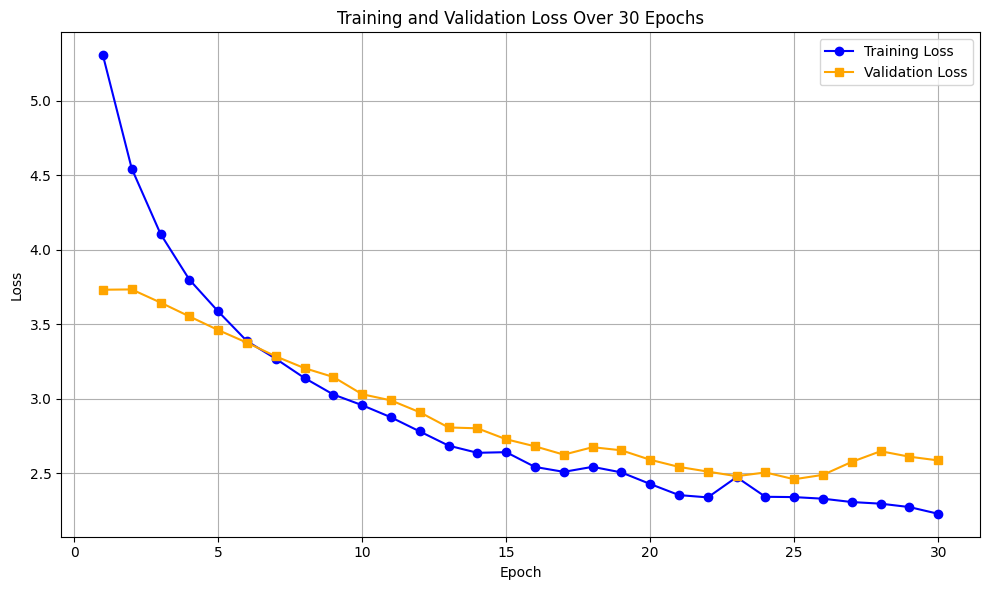

In [ ]:
import matplotlib.pyplot as plt

# Epoch numbers for 30 epochs
epochs = list(range(1, 31))

# Training Losses
training_loss = [
    5.3051, 4.5447, 4.1057, 3.7991, 3.5856,
    3.3860, 3.2677, 3.1381, 3.0275, 2.9558,
    2.8746, 2.7796, 2.6844, 2.6362, 2.6404,
    2.5412, 2.5083, 2.5419, 2.5045, 2.4268,
    2.3523, 2.3368, 2.4729, 2.3409, 2.3388,
    2.3280, 2.3056, 2.2947, 2.2718, 2.2267
]

# Validation Losses
validation_loss = [
    3.7310, 3.7330, 3.6448, 3.5520, 3.4604,
    3.3755, 3.2837, 3.2044, 3.1451, 3.0294,
    2.9881, 2.9086, 2.8063, 2.8006, 2.7270,
    2.6796, 2.6238, 2.6738, 2.6529, 2.5894,
    2.5414, 2.5101, 2.4791, 2.5044, 2.4586,
    2.4882, 2.5754, 2.6468, 2.6100, 2.5850
]

# Plot configuration
plt.figure(figsize=(10, 6))

# Plot Training Loss
plt.plot(epochs, training_loss, marker='o', label='Training Loss', color='blue')

# Plot Validation Loss
plt.plot(epochs, validation_loss, marker='s', label='Validation Loss', color='orange')

# Adding titles and labels
plt.title('Training and Validation Loss Over 30 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


# **Step 5: Evaluating the Model**

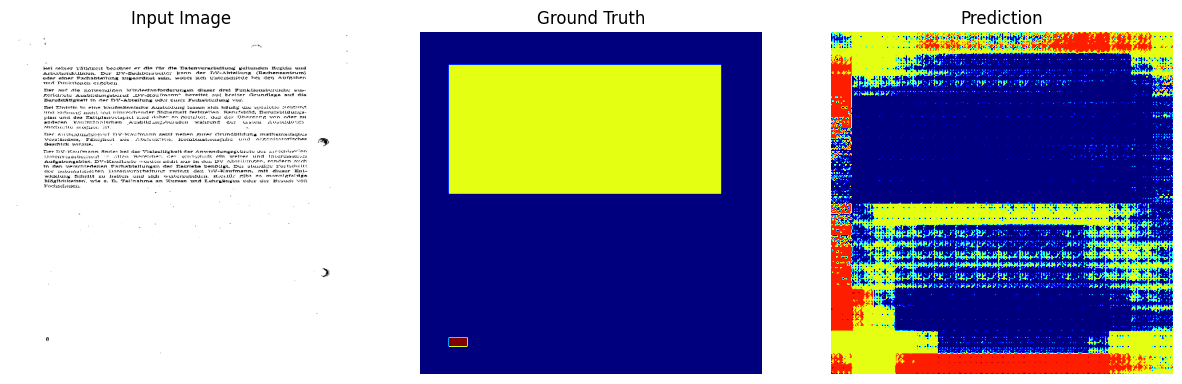

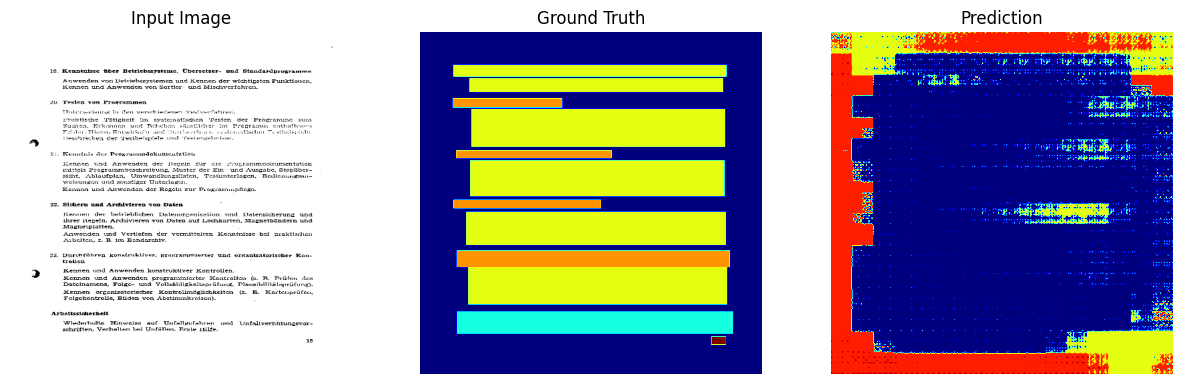

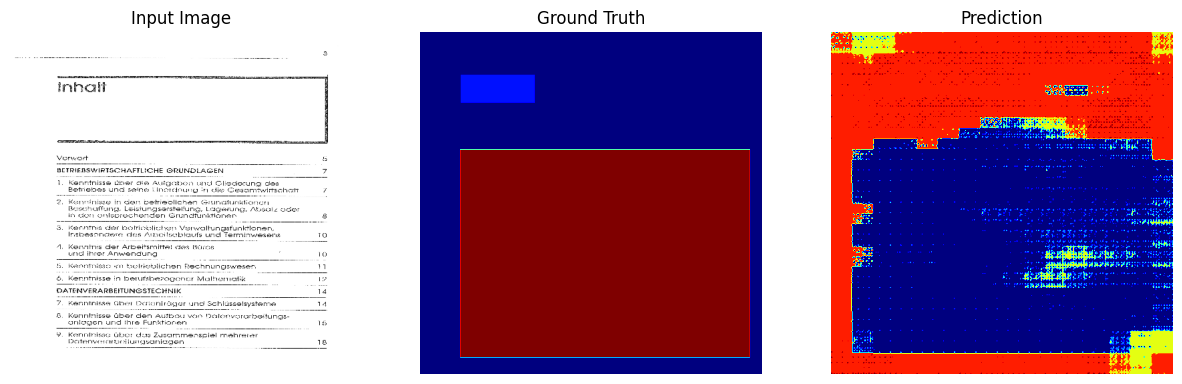

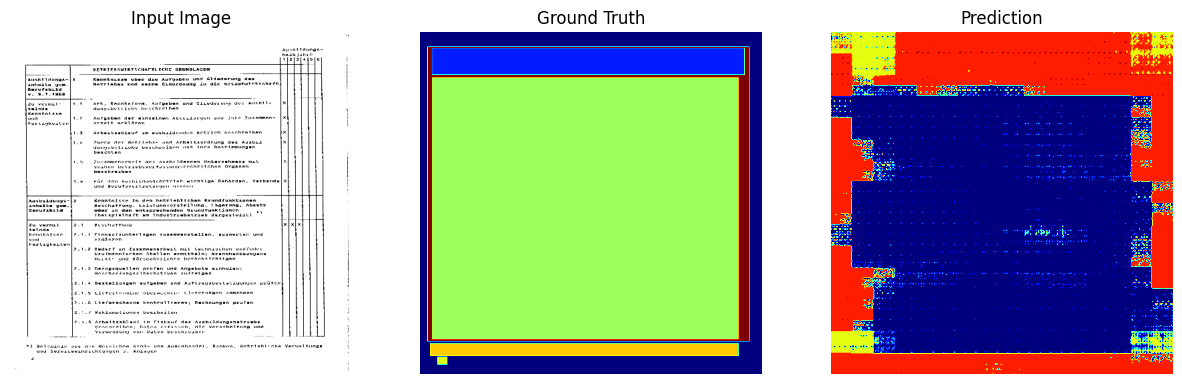

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images_displayed = 0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            # Assuming your model returns a tuple of (outputs, reconstructions, features)
            outputs, _, _ = model(images)  # Unpack the tuple, taking only the outputs
            #outputs = model(images)[0] #or use indexing
            outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
            preds = torch.argmax(outputs, dim=1)
            for i in range(images.size(0)):
                if images_displayed >= num_images:
                    return
                image = images[i, :3, :, :].cpu().numpy().transpose(1, 2, 0)
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()

                plt.figure(figsize=(15,5))
                plt.subplot(1,3,1)
                plt.title('Input Image')
                plt.imshow(image)
                plt.axis('off')

                plt.subplot(1,3,2)
                plt.title('Ground Truth')
                plt.imshow(mask, cmap='jet')
                plt.axis('off')

                plt.subplot(1,3,3)
                plt.title('Prediction')
                plt.imshow(pred, cmap='jet')
                plt.axis('off')

                plt.show()
                images_displayed += 1

# Visualize
visualize_predictions(model, val_loader)

In [ ]:
def calculate_iou(preds, masks, num_classes):
    iou_list = []
    preds = preds.view(-1)
    masks = masks.view(-1)
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            iou = float('nan')
        else:
            iou = float(intersection) / float(max(union, 1))
        iou_list.append(iou)
    return iou_list

# Calculate IoU on the validation set
model.eval()
all_iou = []
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        # Assuming your model returns a tuple of (outputs, reconstructions, features)
        outputs, _, _ = model(images)  # Unpack the tuple, taking only the outputs
        #outputs = model(images)[0] #or use indexing

        outputs = F.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        preds = torch.argmax(outputs, dim=1)
        iou = calculate_iou(preds, masks, num_classes)
        all_iou.append(iou)

# Calculate mean IoU per class
mean_iou = np.nanmean(np.array(all_iou), axis=0)
for cls in range(num_classes):
    print(f"Class {cls}: IoU = {mean_iou[cls]:.4f}")


Class 0: IoU = 0.0000
Class 1: IoU = 0.0000
Class 2: IoU = 0.0000
Class 3: IoU = 0.0187
Class 4: IoU = nan
Class 5: IoU = 0.0032
Class 6: IoU = 0.0018
Class 7: IoU = 0.0001
Class 8: IoU = 0.0041
Class 9: IoU = 0.0000
Class 10: IoU = 0.0000
Class 11: IoU = 0.0000
Class 12: IoU = nan
Class 13: IoU = 0.0000
Class 14: IoU = nan


<ipython-input-31-cdad52a2c089>:34: RuntimeWarning: Mean of empty slice
  mean_iou = np.nanmean(np.array(all_iou), axis=0)


In [ ]:
unique_classes = np.unique(preds.cpu().numpy())
print(f"Unique classes in prediction: {unique_classes}")


Unique classes in prediction: [ 3  5  6  7  8  9 10 11]


In [ ]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(preds, masks, num_classes):
    preds = preds.flatten().cpu().numpy()
    masks = masks.flatten().cpu().numpy()
    cm = confusion_matrix(masks, preds, labels=range(num_classes))
    return cm

# Example usage:
cm = compute_confusion_matrix(preds, masks, num_classes)
print(cm)



[[     0      0      0  23471      0     34   2303      5  10806      1
  123716   2796      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
    4597     65      0      0      0]
 [     0      0      0     51      0      0     26      0   3078      6
   15267    292      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0]
 [     0      0      0 278953      0   2596   4923     49   5128      1
   23167     85      0      0      0]
 [     0      0      0      0      0      0      0      0      0      0
     180      0      0      0      0]
 [     0  